# Important (5 November 2020)
Please note that this ipynb uses the *Categories.csv* file which was generated by Coleen who included two additional web-scrapped columns of data.  

Please ensure that you are using the correct file before running this ipynb.  

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import graphviz 
from sklearn.metrics import accuracy_score,f1_score,precision_score,roc_auc_score,recall_score,confusion_matrix

import statsmodels.formula.api as smf
np.random.seed(3101)
%matplotlib inline

# 1. Import Data

#### Sales information  
- Customer ID
- Date of transaction
- Category of product
- Pack size
- Volume purchased
- Amount spent

#### Product information  
- Category of product
- Calories per 100g
- Price per volume

#### Demographic information  
- Customer ID
- Customer BMI category
- Customer income category
- Customer ethnicity category
- Customer lifestage category
- Customer strata category
- Customer household size category
- Customer location

In [2]:
sales = pd.read_csv('../../HackathonInformationAndData/data/DSA3101_Hackathon_Data.csv',
                   dtype = {'Category': 'category', 'Pack Size': 'int',
                           'Volume': 'float', 'Spend': 'float'},
                   parse_dates=[1])
sales.columns = ['id'] + sales.columns.str.split().str.join("_").str.lower()[1:].tolist()
sales.id = sales.id.str.split().str[1].astype(int)

# CSV that Coleen generated using webscraped data
item_info = pd.read_csv('Categories.csv',
                        dtype={'Category': 'category', 'Calories/100g': 'float',
                               'Price per Volume': 'float', 'Saturated Fats/100g': 'float',
                               'Sugar/100g': 'float', 'Sodium (mg)/100g': 'float'})
item_info.columns = ['category', 'calories_per_100g', 'price_per_volume', 'saturated_fats_per_100g', 'sugar_per_100g',
                     'sodium_mg_per_100g']

demographics = pd.read_excel("../../HackathonInformationAndData/data/DSA3101_Hackathon_Panelists_Demographics.xlsx",
                             dtype={'BMI': 'category', 'Income': 'category', 'Ethnicity': 'category', 
                                    'Lifestage': 'category', 'Strata': 'category', '#HH': 'category', 
                                    'location': 'category'})
demographics.columns = demographics.columns.str.lower()
demographics.id = demographics.id.str.split().str[1].astype(int)

In [3]:
# Record the demographic column names
demographic_names = demographics.columns[1:].to_list()

#### The three tables loaded in are:
    1. sales (1318024 by 6)
    2. item_info (62 by 6)
    3. demographics (4026 by 8)

Now we combine all the data tables into one

In [4]:
data = sales.merge(demographics, on='id').merge(item_info, on="category")
data.set_index('id', inplace=True)

In [5]:
data.head(2)

,date,category,pack_size,volume,spend,bmi,income,ethnicity,lifestage,strata,#hh,location,calories_per_100g,price_per_volume,saturated_fats_per_100g,sugar_per_100g,sodium_mg_per_100g
id,,,,,,,,,,,,,,,,,
101011101,2017-07-02,CSD,1,1.5,1.5,Obese,Income 1500 - 1999,North Malay,Empty Nesters,Urban,1-3 Member HH,North,44.0,2.2,0.0,10.6,75.0
101011101,2018-06-03,CSD,48,72.0,75.8,Obese,Income 1500 - 1999,North Malay,Empty Nesters,Urban,1-3 Member HH,North,44.0,2.2,0.0,10.6,75.0


# 2. Data cleaning and preparation

In [6]:
# Create a column for calories
data.loc[:, 'calories'] = (data.volume * data.calories_per_100g)

# Demographic mapping:
lifestage_mapping = {'Nesting Families': '<10 (kids)',
                     'Teens and Toddlers': '<10 and 10-19 (kids)',
                     'Teens Aches': '10-19 (kids)',
                     'Yankys': '20-44 (no kids)',
                     'Matured Families': '20-44 and 45+ (no kids)',
                     'Empty Nesters': '45+ (no kids)'}
data.loc[:, 'lifestage'] = data.lifestage.map(lifestage_mapping)

In [7]:
count_spend_zero = (data.spend == 0).sum()
data = data.loc[data.spend != 0,:]
print(f"Drop {count_spend_zero} rows where no money was spent", end="\n\n")
# None of the spend values are negative

vol_zero = (data.volume==0)
est_volumes = data.loc[vol_zero, 'spend'] / data.loc[vol_zero, 'price_per_volume']
data.loc[vol_zero, 'volume'] = est_volumes
print(f"If volume is zero, estimate Volume of products purchased via Spend / Price per volume", end="\n\n")

count_duplicates = data.duplicated().sum()
data.drop_duplicates(inplace=True)
print(f"Drop {count_duplicates} duplicate rows")

Drop 1291 rows where no money was spent

If volume is zero, estimate Volume of products purchased via Spend / Price per volume

Drop 44032 duplicate rows


In [8]:
num_rows, num_cols = data.shape
print(f"The cleaned data comprises {num_rows:,} rows and {num_cols} columns")

The cleaned data comprises 1,272,701 rows and 18 columns


## Generate start-end data for each customer

Start: When they started doing business with our client  
End: When they stopped doing business with out client  

In [9]:
cust_start = data.groupby('id').date.min()
cust_end = data.groupby('id').date.max()
cust_start_end = cust_start.to_frame().merge(cust_end.to_frame(), left_index=True, right_index=True)
cust_start_end.columns = ['start', 'end']

# 3. Exploratory Data Analysis

#### Distribution of data with respect to dates
Transaction data is recorded on a weekly basis (every Sunday)  
Transaction data appears to be consistently reported across each week, having slight seasonality over a period of 5 weeks. For example, every 5 weeks a spike occurs.  
Note, transactions only started being recorded in Mid 2017 and ended mid 2020, so the transaction counts look proportionate below  


In [10]:
pd.Series(data.sort_values('date').date.unique()).diff().value_counts()

7 days    155
dtype: int64

In [11]:
dates = data.sort_values('date').date

list_of_days = list(dates.dt.isocalendar().day.unique())
print(f"The days of transaction dates are: {list_of_days}")
print("This shows transactions were always recorded on the same day (Sunday)", end="\n\n")
# 7 == Sunday (Ref: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timestamp.isoweekday.html)

print("Transactions were recorded every week (every Sunday)")
print(pd.Series(data.sort_values('date').date.unique()).diff().value_counts())

The days of transaction dates are: [7]
This shows transactions were always recorded on the same day (Sunday)

Transactions were recorded every week (every Sunday)
7 days    155
dtype: int64


In [12]:
dates.groupby([dates.dt.year]).size()

date
2017    239967
2018    419157
2019    415943
2020    197634
Name: date, dtype: int64

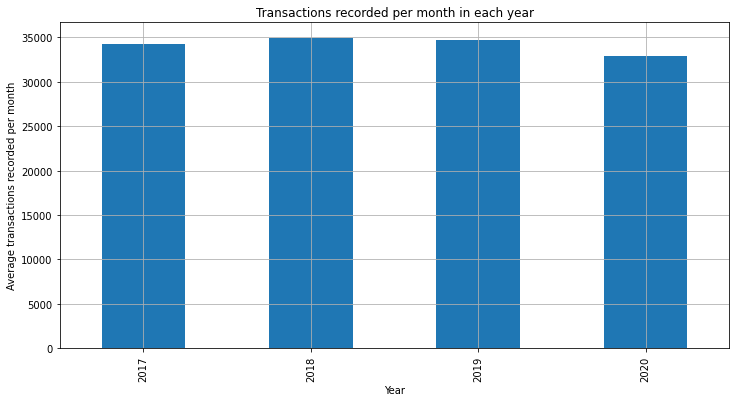

In [13]:
counts_per_year = dates.groupby([dates.dt.year]).size()
months_per_year = dates.groupby(dates.dt.year).apply(lambda dates: dates.dt.month.nunique())
normalized_counts_per_year = counts_per_year / months_per_year

normalized_counts_per_year.plot(kind="bar", grid=True, figsize=(12,6))
plt.title("Transactions recorded per month in each year")
plt.ylabel("Average transactions recorded per month")
plt.xlabel("Year");

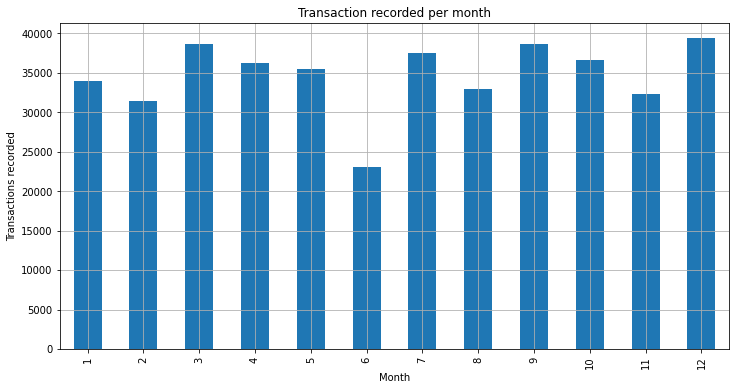

In [14]:
counts_per_month = dates.groupby([dates.dt.month]).size()
count_of_month_in_data = dates.groupby(dates.dt.month).apply(lambda dates: dates.dt.year.nunique())
normalized_counts_per_month = counts_per_month / count_of_month_in_data

normalized_counts_per_month.plot(kind="bar", grid=True, figsize=(12,6))
plt.title("Transaction recorded per month")
plt.ylabel("Transactions recorded")
plt.xlabel("Month");

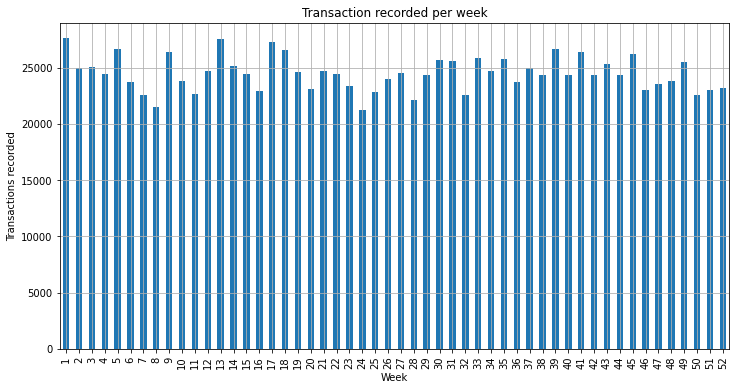

In [15]:
dates.groupby([dates.dt.isocalendar().week]).size().plot(kind="bar", grid=True, figsize=(12,6))
plt.title("Transaction recorded per week")
plt.ylabel("Transactions recorded")
plt.xlabel("Week");

#### Examine how demographics change over time

1. Sales to underweight customers have decreased, falling below sales to obese customers
2. Urban sales fell from 7,000 to approx 6,500
3. Sales figures are usually lower to larger households. A counter-intuitive finding.
4. Sales in the central region, sales have fallen from approximately 3,250 to 3,000
5. The only increases in sales were to Healthy people or people with income > 5000

Note that without data about the broader population, these numbers alone do not give the full picture.
For example, did sales to underweight people decrease because underweight people found better alternatives or because the number of underweight people in Malaysia decreased?  


[Health in Malaysia](https://www.moh.gov.my/moh/penerbitan/MYHAAG2018.pdf)
From this, we learn that diabetes, smoking, and obesity rates generally increased in Malaysia between 2011 and 2015.  
Malaysia has one of the highest rates of diabetes in South-East Asia.  


From Google, we see that Malaysia has had approximately 4% GDP growth rate for the years 2018-2020.  

These suggest that perhaps people in Malaysia have been becoming wealthier, and that perhaps the proportion of underweight people could have decreased.  


In [16]:
def demo_over_time(demo, value='counts', window_size=30, marker='o', figsize=(20,14)):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
    if value == 'counts':
        by_date = data.loc[:, ['date', demo]].groupby(['date', demo]).size().unstack().sort_index()
    elif value == 'spend':
        by_date = data.loc[:, ['date', 'spend', demo]].groupby(['date', demo]).spend.sum().unstack().sort_index()
    by_date.plot(marker=marker, figsize=figsize, ax=ax1);
    plt.ylabel("Weekly Transaction Counts")
    by_date.rolling(window_size).mean().plot(marker=marker, figsize=figsize, ax=ax2)
    plt.ylabel(f"{window_size} week rolling average of transaction {value}")

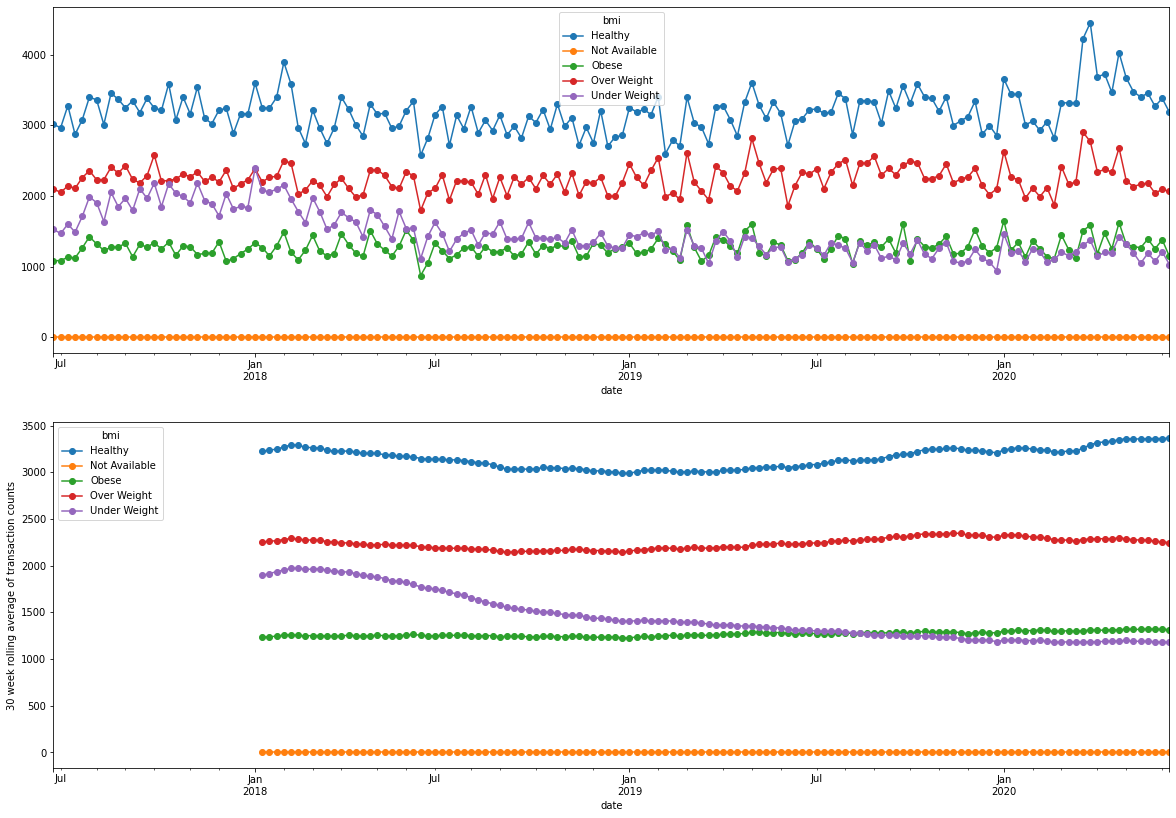

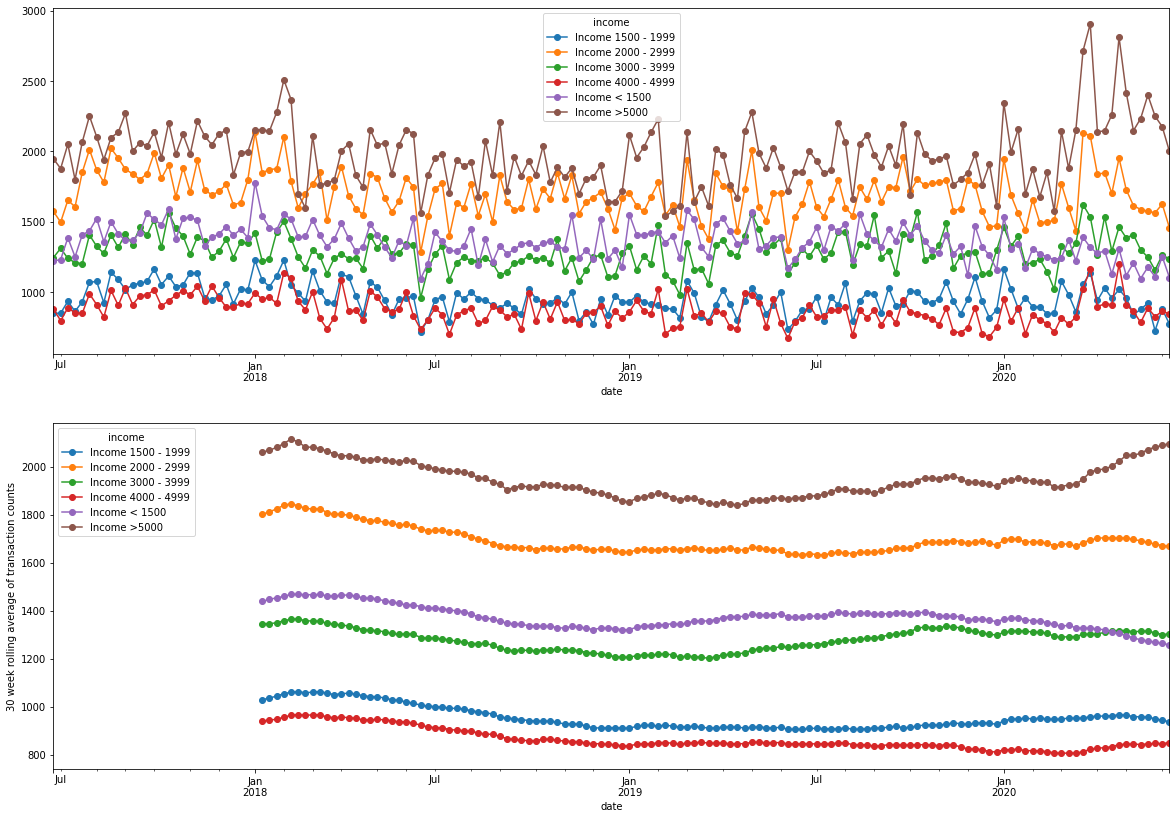

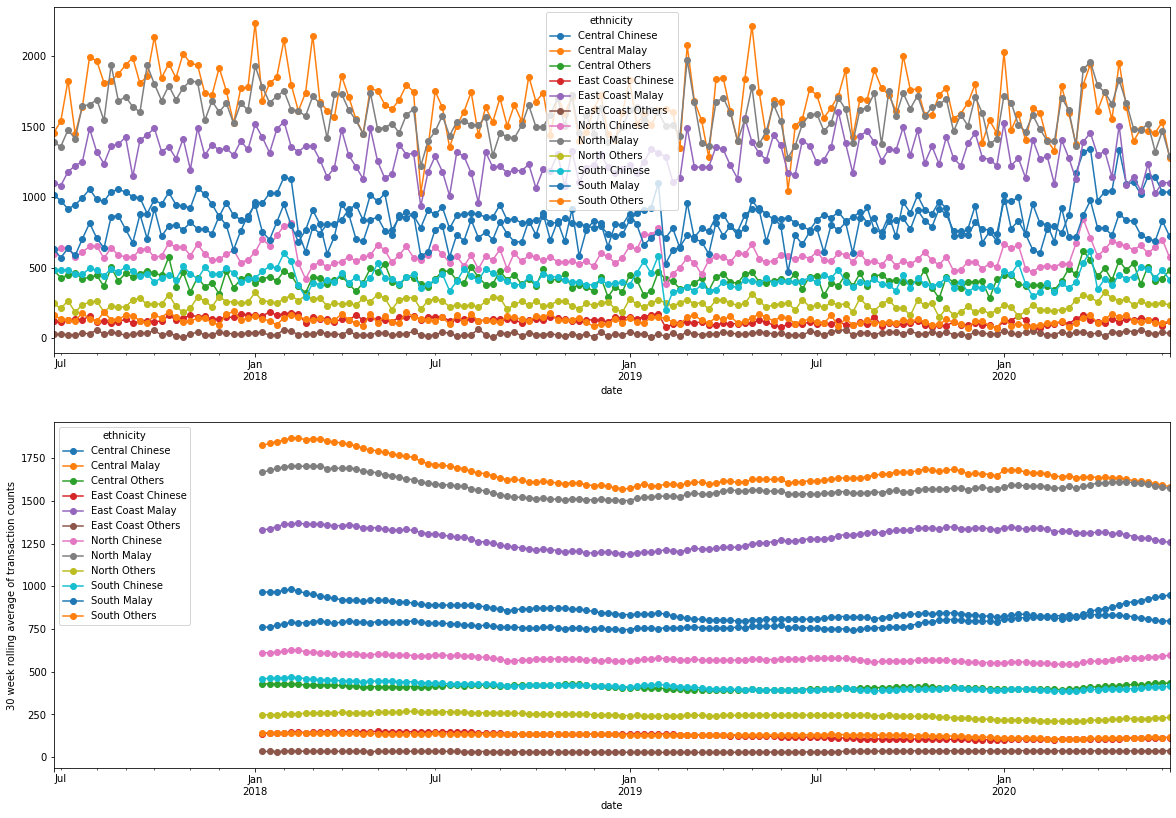

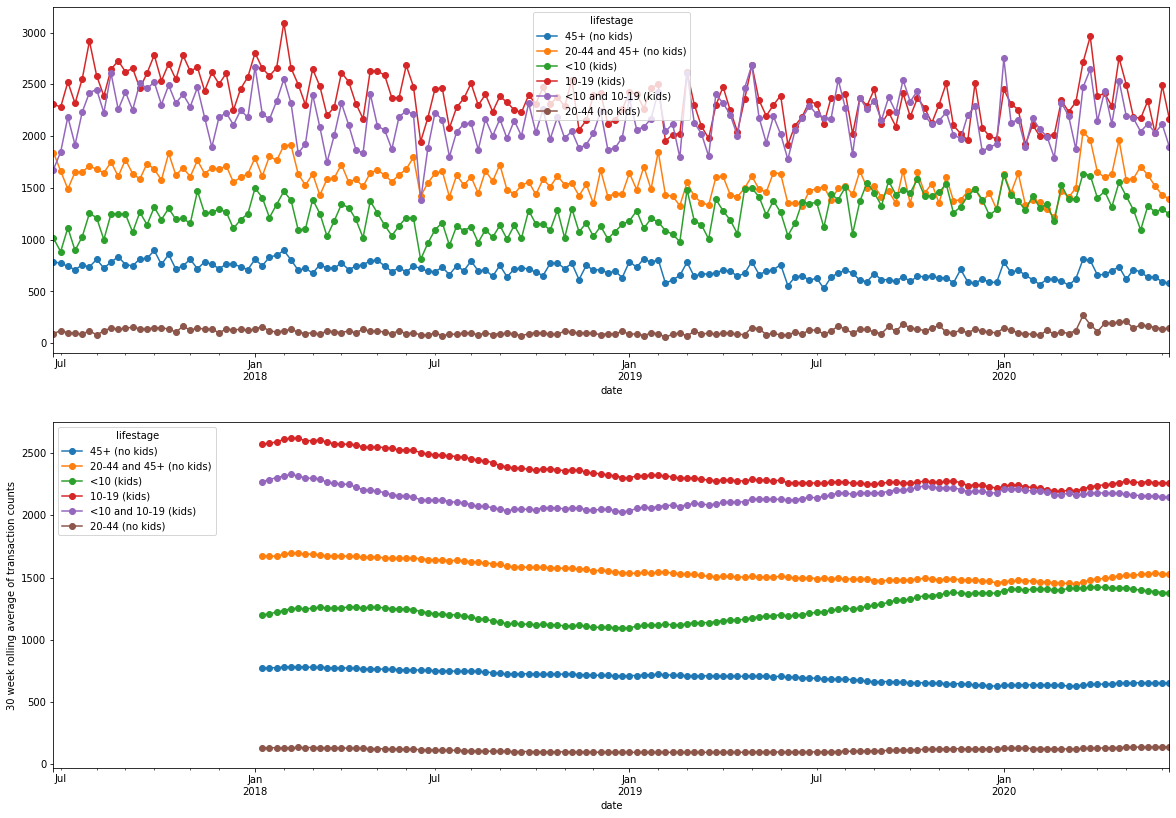

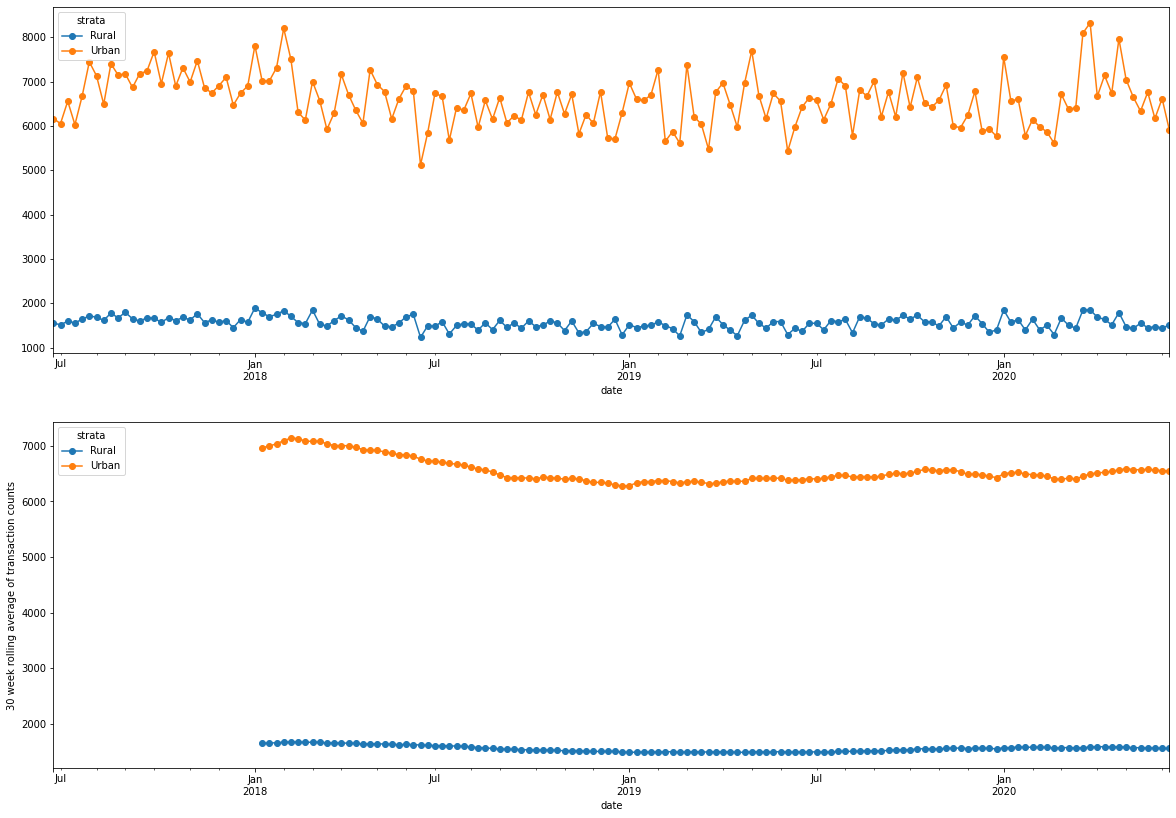

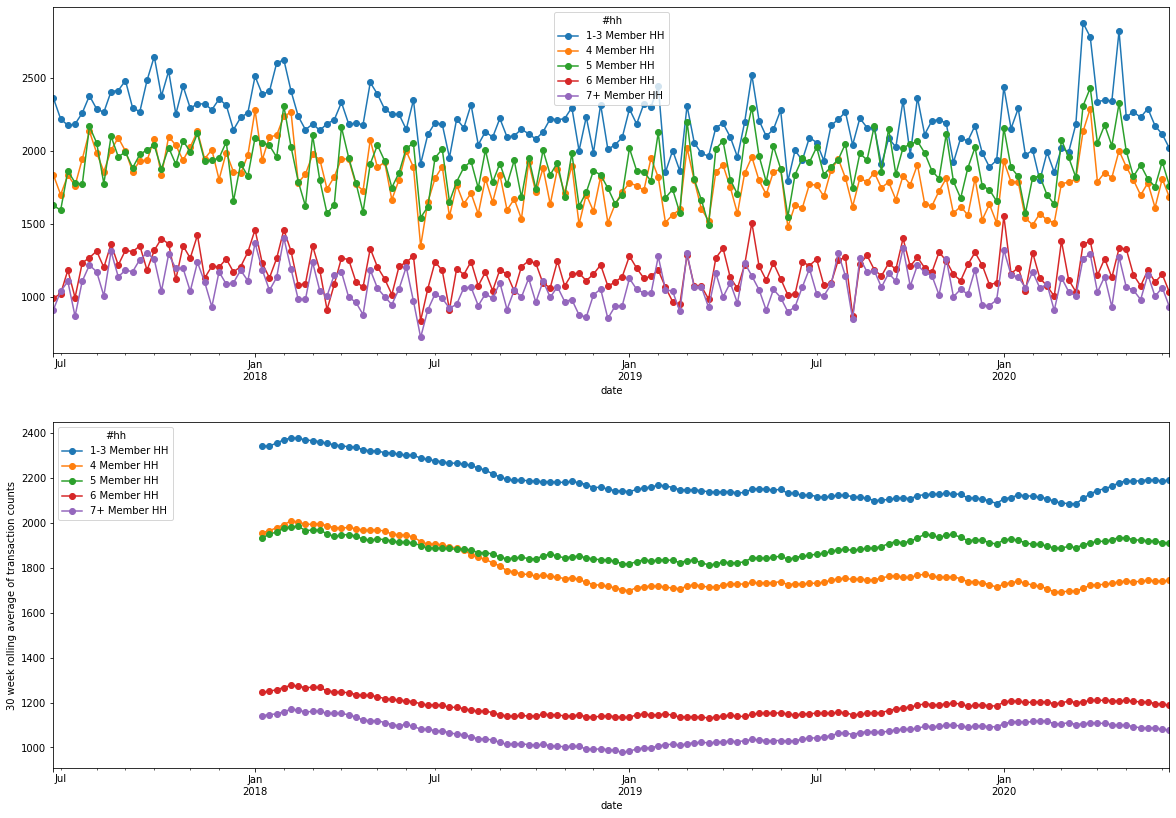

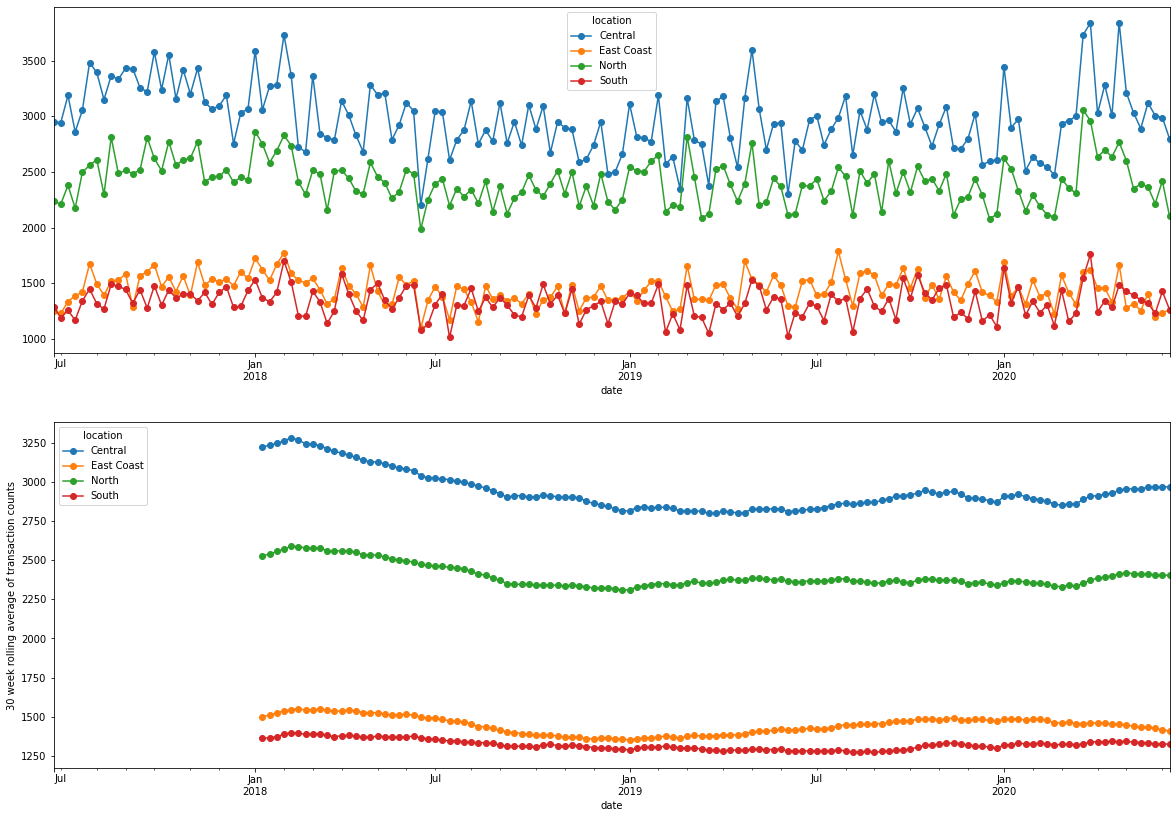

In [17]:
for demo in demographic_names:
    demo_over_time(demo, value='counts')

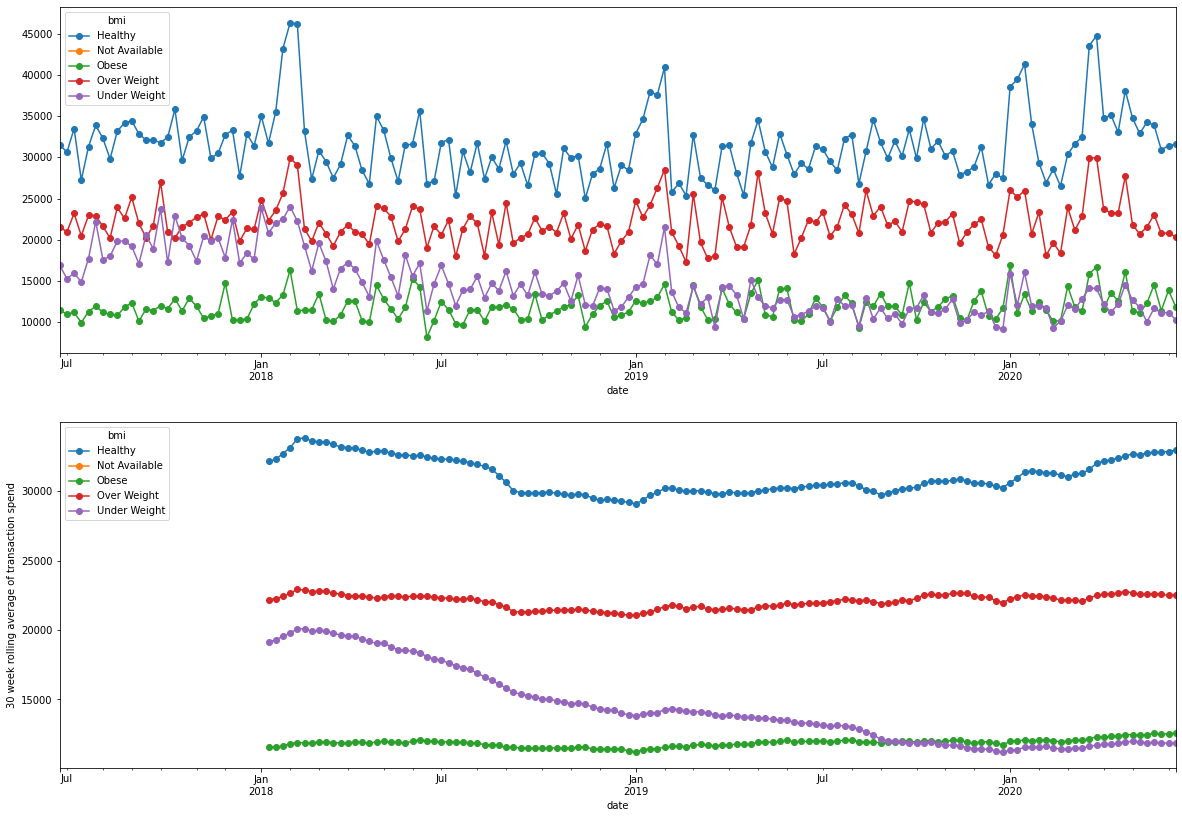

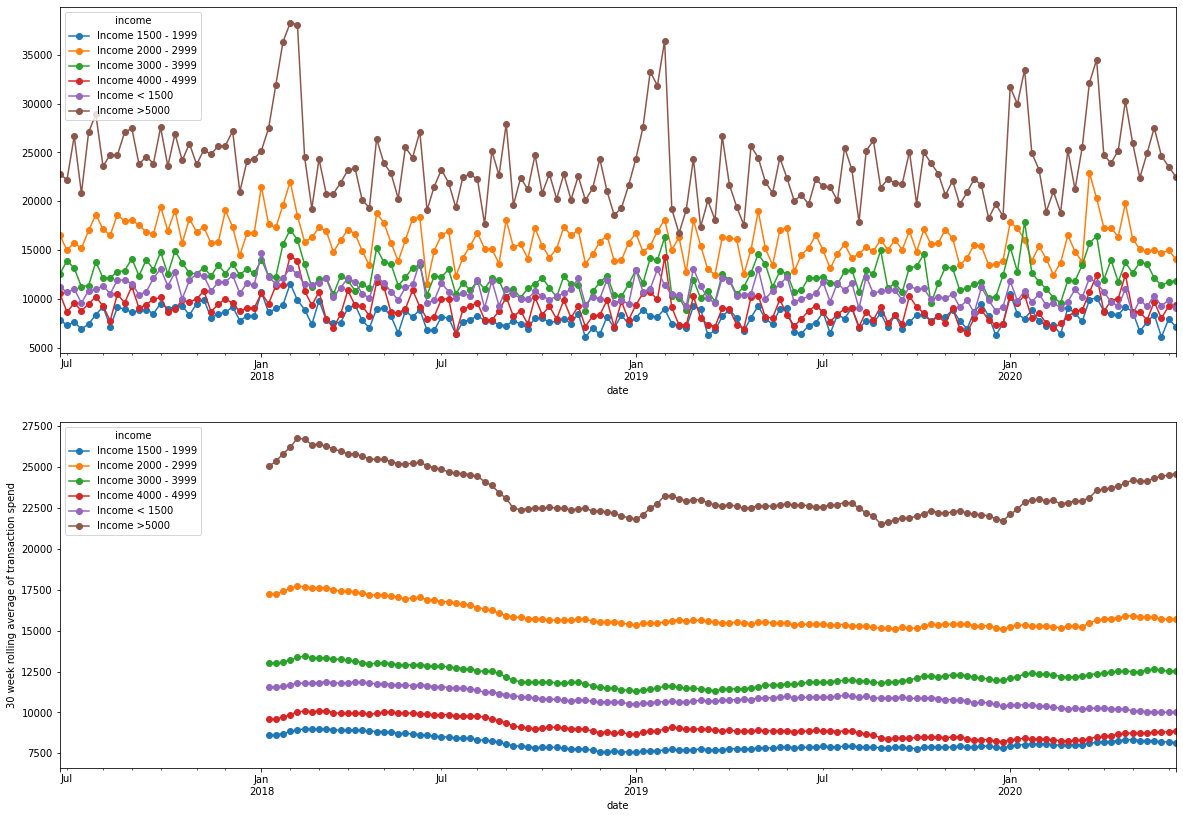

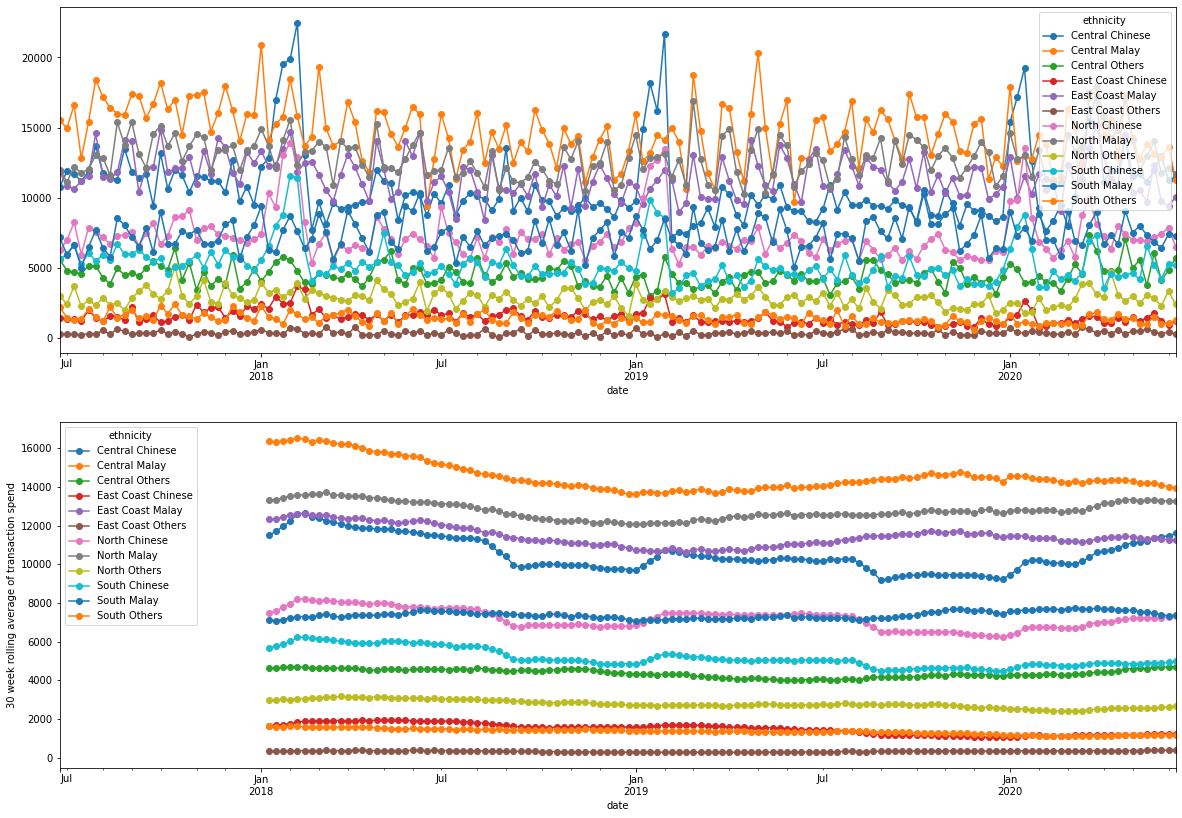

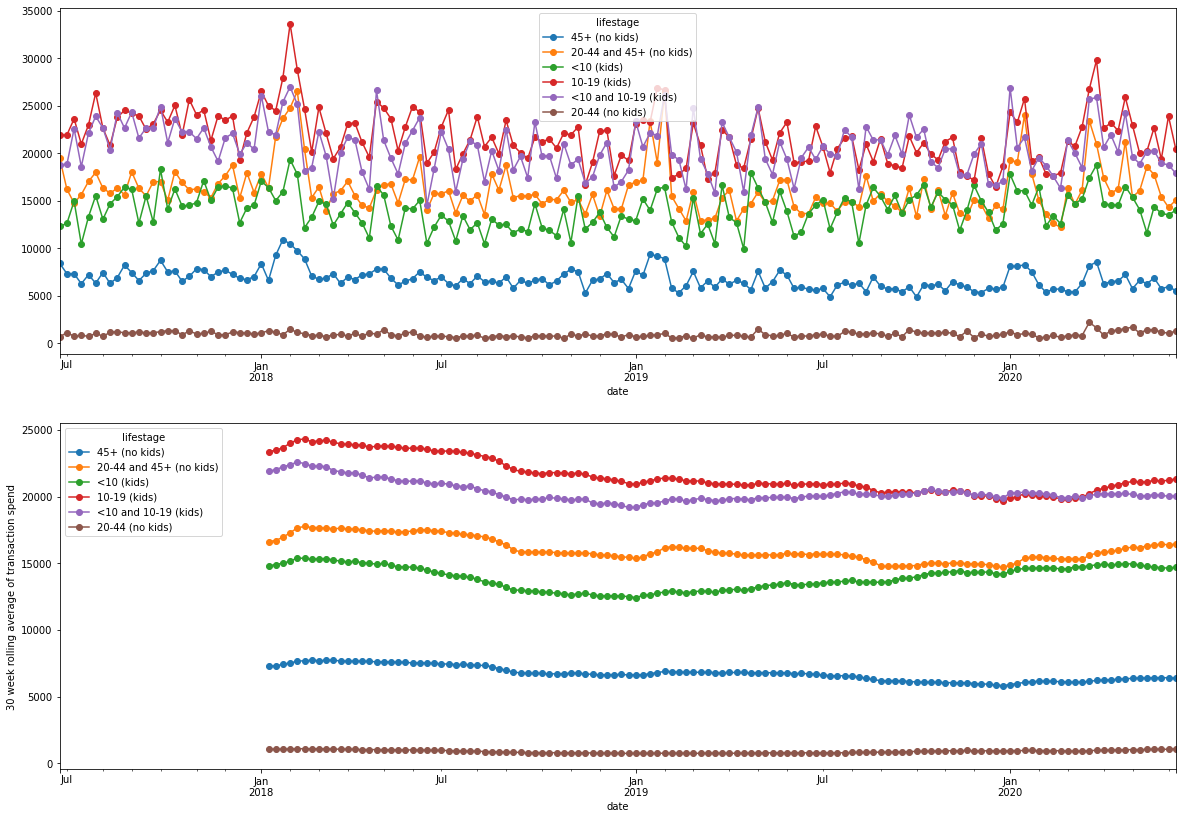

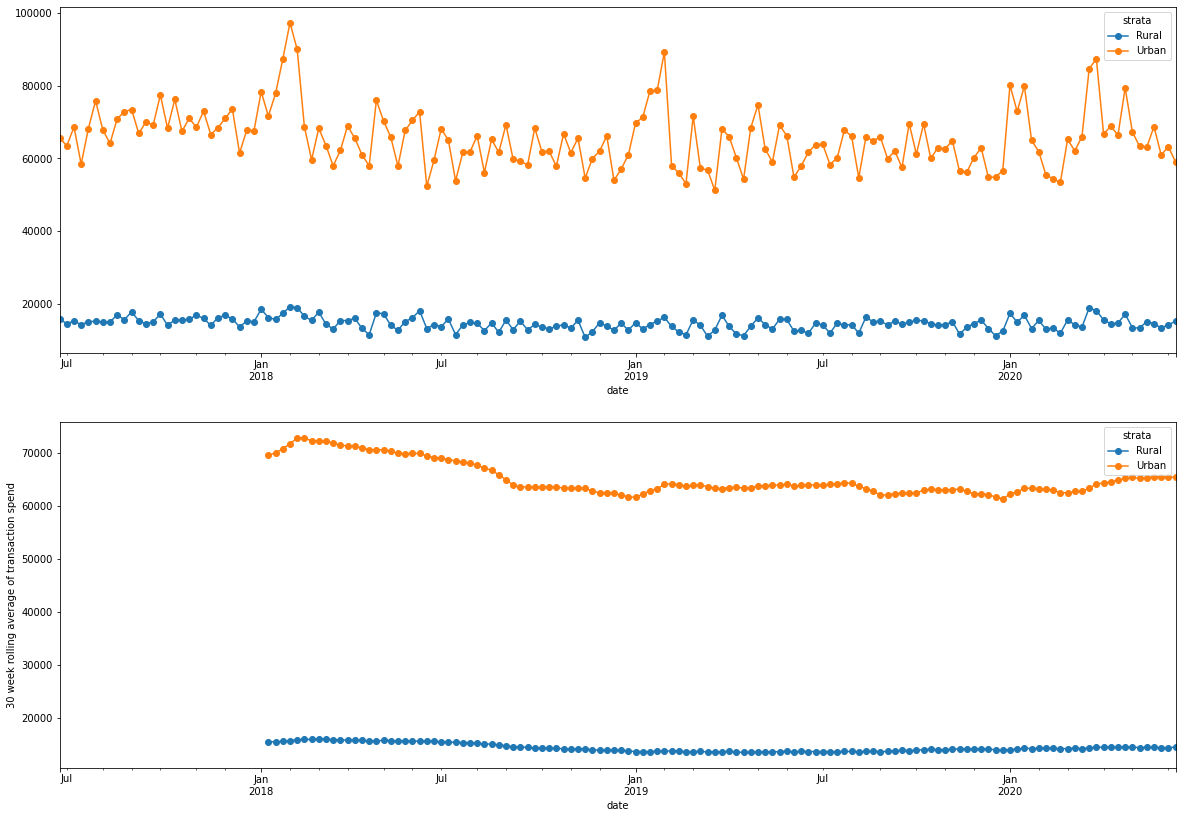

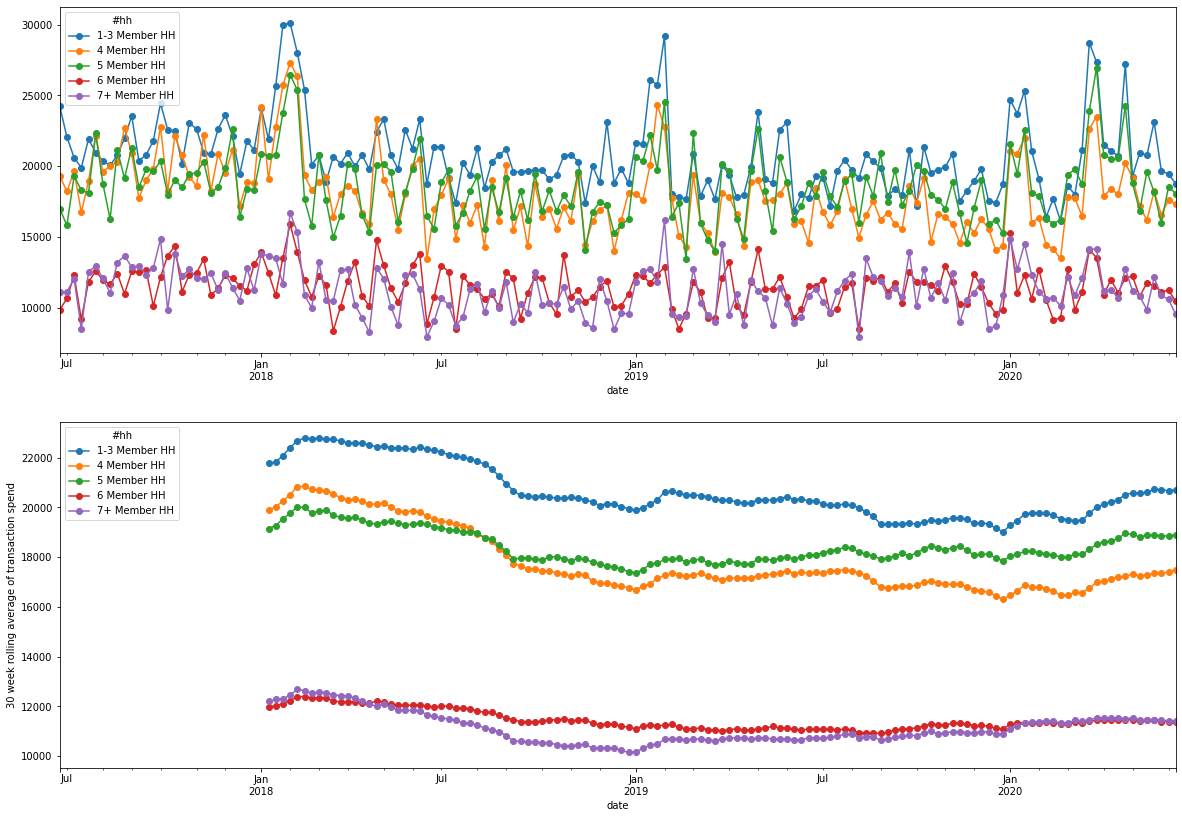

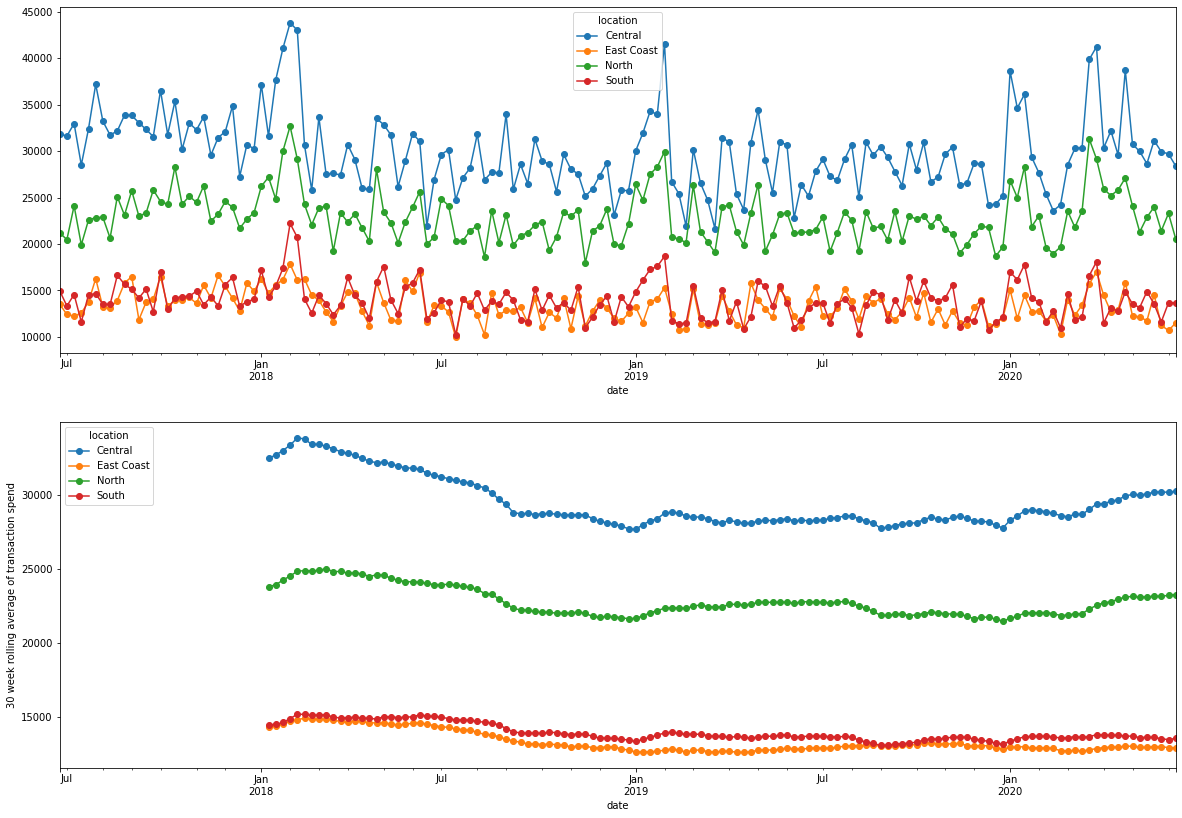

In [18]:
for demo in demographic_names:
    demo_over_time(demo, value='spend')

# 4. Duration-between-visits per customer - Frequency

The data below describes the average number of days between two consecutive visits of the same customer to the client.  

We see that the distribution of durations between visits is right-skew, with a range of 7 to 168 days, and mean of 10.18 days. This skew and the discrete nature of days-between-visits, means that partitioning the days-between-visits may result in unequal groups.  

In an attempt to produce groups of roughly equal size, yet with characteristics that are different enough from one another, I propose the following division:
1. Days-between-visits <= 7
2. 7 < Days-between-visits <= 10
3. 10 < Days-between-visits <= 13
4. 13 < Days-between-visits <= 15
5. 15 < Days-between-visits

This partitioning can be used to generate the Frequency score for RFM scoring, with customers in parition **1** being given Frequency scores of 5, customers in partition **2** being given Frequency scores of 4, etc.  


In [19]:
duration_btw = data.groupby(data.index).date.apply(lambda dates: pd.Series(dates.unique()).sort_values().diff().mean())

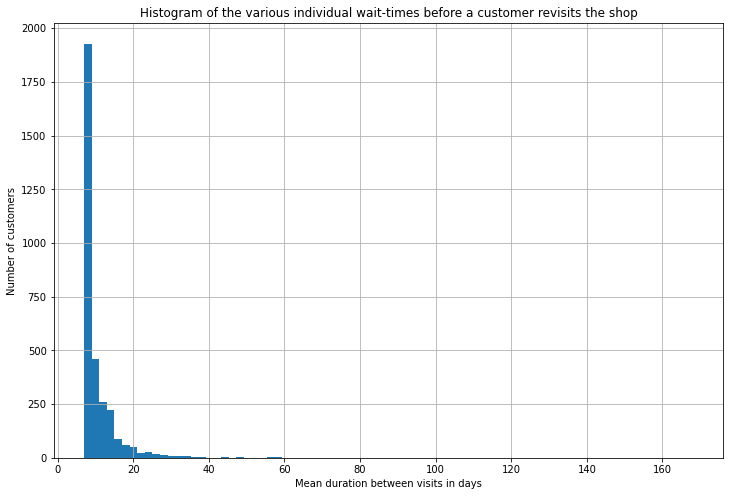

In [20]:
duration_btw.sort_values().reset_index(drop=True).dt.days.hist(bins=80, figsize=(12,8))
plt.ylabel("Number of customers")
plt.xlabel("Mean duration between visits in days")
plt.title("Histogram of the various individual wait-times before a customer revisits the shop");

In [21]:
x = [i for i in np.arange(0,1, 0.01)]
y = [duration_btw.sort_values().reset_index(drop=True).dropna().quantile(i).days for i in x]

In [22]:
d7 = (np.array(y) <= 7).mean()
print(f"{d7 * 100}% of customers return to the shop within  7 days on average")

q80 = duration_btw.sort_values().reset_index(drop=True).dropna().quantile(0.8)
print(f"80.0% of customers return to the shop within {q80.days} days on average", end="\n\n")

d_mean = np.array(y).mean()
print(f"The average duration between visits is {d_mean} days")
d_max = duration_btw.sort_values().reset_index(drop=True).dropna().max().days
print(f"The maximum duration between visits is {d_max} days")

34.0% of customers return to the shop within  7 days on average
80.0% of customers return to the shop within 13 days on average

The average duration between visits is 10.18 days
The maximum duration between visits is 168 days


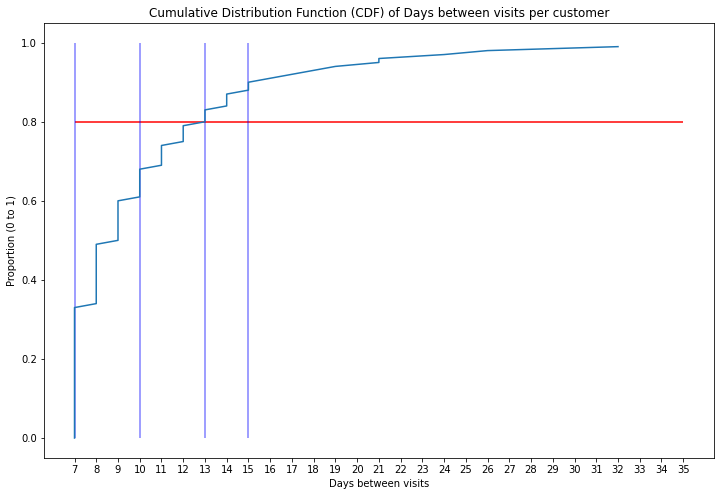

In [23]:
plt.figure(figsize=(12,8))
plt.plot(y, x)
plt.hlines(y=0.8, xmin=7, xmax=35, color="r")
plt.vlines(x=7, ymin=0, ymax=1, color="b", alpha=0.5)
plt.vlines(x=10, ymin=0, ymax=1, color="b", alpha=0.5)
plt.vlines(x=13, ymin=0, ymax=1, color="b", alpha=0.5)
plt.vlines(x=15, ymin=0, ymax=1, color="b", alpha=0.5)
plt.xticks([_ for _ in range(7, 36)])

plt.title("Cumulative Distribution Function (CDF) of Days between visits per customer")
plt.ylabel("Proportion (0 to 1)")
plt.xlabel("Days between visits");

In [24]:
def partition_frequency(days):
    if days <= 7:
        return 5
    elif days <= 10:
        return 4
    elif days <= 13:
        return 3
    elif days <= 15:
        return 2
    else:
        return 1

# 5. Customer segmentation into Healthy and Non-Healthy

1. Generates health scores for every product sold
2. Computes health labels for each customer, based on the average health score of items they bought
3. Use **only** demographic data to predict (via Decision Tree) a customers health label

Health scores for each product are generated according to the following procedure:

1. Standardize each of the four columns: *calories per 100g, saturated fats per 100g, sugar per 100g, sodium in mg per 100g*
2. Translate each column so that each of their minimum values is 1. (I.e. add a fixed constant to every value in the column, so that the min is 1)
3. For each item, multiply its final scores for *calories per 100g, saturated fats per 100g, sugar per 100g, sodium in mg per 100g* to generate its final health score. This health score will be $\geq$ 1, since the smallest value possible is $1 \times 1 \times 1 \times 1 = 1$

The rationale here is that a multiplicative health score will compound the effects of every contributor. So 3 low and 1 high will be lower than 2 low and 2 high.  E.g. $1 \times 1 \times 1 \times 10 = 10 < 1 \times 1 \times 5 \times 5 = 25$

In [25]:
food_quality_columns = ['calories_per_100g', 'saturated_fats_per_100g', 'sugar_per_100g', 'sodium_mg_per_100g']

Select numerical columns to standardize

In [26]:
temp = item_info.loc[:, food_quality_columns]
temp.head()

,calories_per_100g,saturated_fats_per_100g,sugar_per_100g,sodium_mg_per_100g
0,188.0,0.80,0.90,3.0
1,43.0,0.00,0.00,4.0
2,563.0,1.38,0.45,7918.0
3,46.0,0.00,0.00,2.0
4,416.0,4.30,2.20,580.0


Standardize

In [27]:
temp2 = (temp - temp.mean())/temp.std()
temp2.head()

,calories_per_100g,saturated_fats_per_100g,sugar_per_100g,sodium_mg_per_100g
0,-0.275219,-0.458158,-0.654060,-0.290371
1,-0.990519,-0.527657,-0.693989,-0.290119
2,1.574693,-0.407772,-0.674024,1.704940
3,-0.975720,-0.527657,-0.693989,-0.290623
4,0.849528,-0.154102,-0.596386,-0.144914


COMMENTED OUT: Translate each column by a fixed constant so that the minimum of each column is 1

In [28]:
temp3 = temp2 - temp2.min() + 1
temp3.head()

,calories_per_100g,saturated_fats_per_100g,sugar_per_100g,sodium_mg_per_100g
0,1.927423,1.069499,1.039928,1.000756
1,1.212123,1.000000,1.000000,1.001008
2,3.777335,1.119885,1.019964,2.996068
3,1.226923,1.000000,1.000000,1.000504
4,3.052170,1.373555,1.097603,1.146214


Multiply columns to produce health score for each item  

Reattach back the category column, identifying which item each row represents

In [29]:
temp3.loc[:, 'health_score'] = temp3.iloc[:,0] * temp3.iloc[:,1] * temp3.iloc[:,2] * temp3.iloc[:,3]
temp3.loc[:, 'category'] = item_info.category

In [30]:
temp3.head()

,calories_per_100g,saturated_fats_per_100g,sugar_per_100g,sodium_mg_per_100g,health_score,category
0,1.927423,1.069499,1.039928,1.000756,2.145305,Baby Cereal
1,1.212123,1.000000,1.000000,1.001008,1.213346,Beer
2,3.777335,1.119885,1.019964,2.996068,12.926934,Belacan
3,1.226923,1.000000,1.000000,1.000504,1.227541,Bird Nest
4,3.052170,1.373555,1.097603,1.146214,5.274308,Biscuits


Select only the category and health score, i.e. **Item Name and Item health score**

In [31]:
item_health = temp3.loc[:, ['category', 'health_score']].sort_values('health_score').reset_index(drop=True)

In [32]:
item_health.head()

,category,health_score
0,Drinking Water,1.000000
1,Coffee,1.005440
2,Tea,1.005946
3,Isotonic Drinks,1.143192
4,Beer,1.213346


In [33]:
item_health.head(60)

,category,health_score
0,Drinking Water,1.000000
1,Coffee,1.005440
2,Tea,1.005946
3,Isotonic Drinks,1.143192
4,Beer,1.213346
5,Bird Nest,1.227541
6,Soy Milk,1.391555
7,Wine,1.461311
8,RTD Coffee,1.639647
9,Milk Powder-Adult,1.699164


Merge these item health_scores with the full data (Note health_score is the last column)

In [34]:
data_health = data.reset_index().merge(item_health, on='category')

In [35]:
data_health.head()

,id,date,category,pack_size,volume,spend,bmi,income,ethnicity,lifestage,strata,#hh,location,calories_per_100g,price_per_volume,saturated_fats_per_100g,sugar_per_100g,sodium_mg_per_100g,calories,health_score
0,101011101,2017-07-02,CSD,1,1.5,1.5,Obese,Income 1500 - 1999,North Malay,45+ (no kids),Urban,1-3 Member HH,North,44.0,2.2,0.0,10.6,75.0,66.0,1.823231
1,101011101,2018-06-03,CSD,48,72.0,75.8,Obese,Income 1500 - 1999,North Malay,45+ (no kids),Urban,1-3 Member HH,North,44.0,2.2,0.0,10.6,75.0,3168.0,1.823231
2,101011101,2020-04-19,CSD,1,1.5,2.7,Obese,Income 1500 - 1999,North Malay,45+ (no kids),Urban,1-3 Member HH,North,44.0,2.2,0.0,10.6,75.0,66.0,1.823231
3,101011101,2020-05-17,CSD,2,3.5,6.2,Obese,Income 1500 - 1999,North Malay,45+ (no kids),Urban,1-3 Member HH,North,44.0,2.2,0.0,10.6,75.0,154.0,1.823231
4,101011101,2020-05-17,CSD,2,3.0,5.9,Obese,Income 1500 - 1999,North Malay,45+ (no kids),Urban,1-3 Member HH,North,44.0,2.2,0.0,10.6,75.0,132.0,1.823231


Compute the health score of each customer by averaging over the health scores of all the items they ever bought  

This is using **health score of item** to compute **health score of person**

In [36]:
health_scores = data_health.groupby('id').health_score.mean()

In [37]:
health_scores.head()

id
101011101    8.472574
101016101    9.963634
101019101    8.109419
101024101    6.187083
105009103    8.652888
Name: health_score, dtype: float64

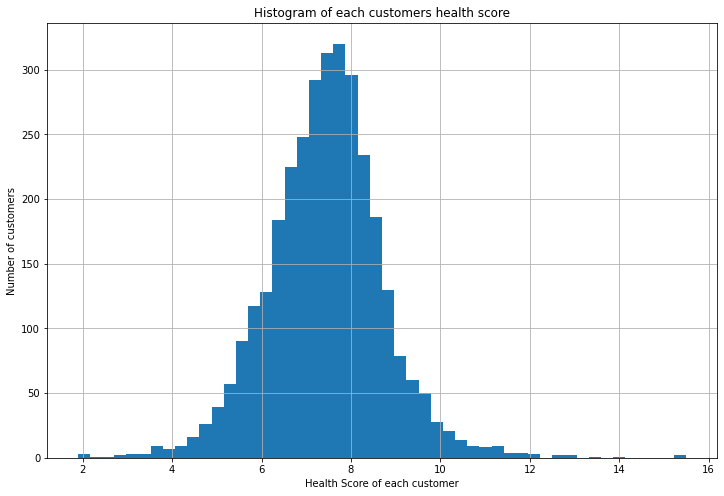

In [38]:
health_scores.hist(bins=50, figsize=(12,8))
plt.title("Histogram of each customers health score")
plt.ylabel("Number of customers")
plt.xlabel("Health Score of each customer");

Label customers with below median health scores as health conscious (0) and those with above median health_scores as non-health conscious (1).

In [39]:
health_scores = pd.cut(health_scores, [health_scores.min()-1, health_scores.median(), health_scores.max()]).cat.codes

In [40]:
health_scores.name = "health_score"

In [41]:
health_scores.head()

id
101011101    1
101016101    1
101019101    1
101024101    0
105009103    1
Name: health_score, dtype: int8

#### Merge with demographic data provided by Kantar

In [42]:
health_demographics = demographics.merge(health_scores.reset_index(), on="id")

In [43]:
health_demographics.head()

,id,bmi,income,ethnicity,lifestage,strata,#hh,location,health_score
0,101011101,Obese,Income 1500 - 1999,North Malay,Empty Nesters,Urban,1-3 Member HH,North,1
1,101016101,Healthy,Income 1500 - 1999,North Malay,Teens Aches,Urban,1-3 Member HH,North,1
2,101019101,Obese,Income < 1500,North Malay,Teens Aches,Urban,4 Member HH,North,1
3,101024101,Over Weight,Income 1500 - 1999,North Chinese,Nesting Families,Urban,1-3 Member HH,North,0
4,105009103,Over Weight,Income < 1500,North Malay,Empty Nesters,Rural,1-3 Member HH,North,1


In [44]:
# Create indicator random variables for Classification Tree
health_demographics_dummy = pd.get_dummies(health_demographics)

# Drop ID as ID cannot be used to predict if someone is healthy (i.e. a new customer's ID wouldnt be any use)
health_demographics_dummy.drop('id', axis=1, inplace=True)

In [45]:
health_demographics_dummy.head()

,health_score,bmi_Healthy,bmi_Not Available,bmi_Obese,bmi_Over Weight,bmi_Under Weight,income_Income 1500 - 1999,income_Income 2000 - 2999,income_Income 3000 - 3999,income_Income 4000 - 4999,...,strata_Urban,#hh_1-3 Member HH,#hh_4 Member HH,#hh_5 Member HH,#hh_6 Member HH,#hh_7+ Member HH,location_Central,location_East Coast,location_North,location_South
0,1,0,0,1,0,0,1,0,0,0,...,1,1,0,0,0,0,0,0,1,0
1,1,1,0,0,0,0,1,0,0,0,...,1,1,0,0,0,0,0,0,1,0
2,1,0,0,1,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0
3,0,0,0,0,1,0,1,0,0,0,...,1,1,0,0,0,0,0,0,1,0
4,1,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


# 6. Decision Tree modelling
#### Please note:
**0: Healthy**
**1: Not healthy**

In [46]:
X_train, X_test, y_train, y_test = train_test_split(health_demographics_dummy.drop('health_score', axis=1),
                                                    health_demographics_dummy.health_score,
                                                    test_size=0.25,
                                                    random_state=1)

clf = DecisionTreeClassifier(random_state=1, criterion='gini', min_samples_split=100, min_samples_leaf=100)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

cm = pd.DataFrame(confusion_matrix(y_pred, y_test))
cm.columns = ['Health-conscious', 'Non-health-conscious']
cm.index = ['Health-conscious', 'Non-health-conscious']
cm.columns.name = 'Actual'
cm.index.name = 'Prediction'
display(cm)

print("Accuracy:",round(accuracy_score(y_test, y_pred),4))
print('Sensitivity',round(cm.iloc[0,0]/(cm.iloc[0,0] + cm.iloc[1,0]), 4))
print("Specificity: ", round(cm.iloc[1,1]/(cm.iloc[0,1] + cm.iloc[1,1]), 4))
print('F1-Score:', round(f1_score(y_test,y_pred),4))
print('AUC:',round(roc_auc_score(y_test, y_pred),4))

Actual,Health-conscious,Non-health-conscious
Prediction,,
Health-conscious,258,97
Non-health-conscious,145,309


Accuracy: 0.7009
Sensitivity 0.6402
Specificity:  0.7611
F1-Score: 0.7186
AUC: 0.7006


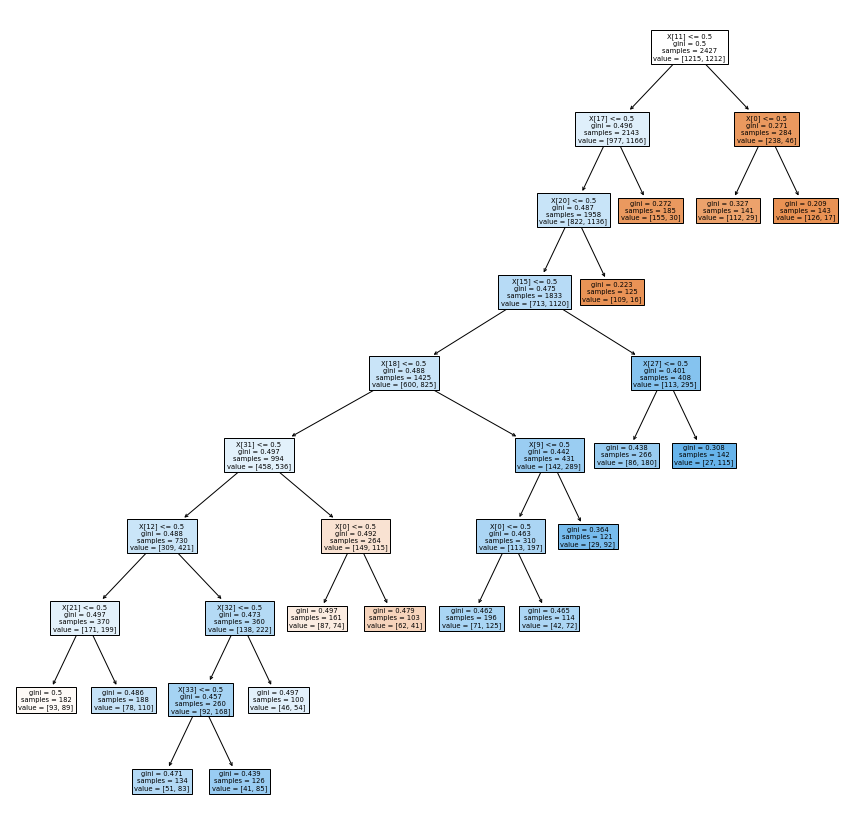

In [47]:
plt.figure(figsize=(15,15))
tree.plot_tree(clf,filled=True);
plt.savefig('tree.jpg',format='jpg',bbox_inches = "tight")

In [48]:
def get_feature_name(number):
    return health_demographics_dummy.drop('health_score', axis=1).iloc[:, number].name

In [49]:
numbers = [9]
for number in numbers:
    print(get_feature_name(number))

income_Income < 1500


## Further questions:

1. Is there a better way to engineer the health scores of items apart from just standardizing, translating, then multiplying?  
2. Given that the above Classification Tree seems to mainly use Geographical splits, analyse different food purchasing habits across the geographies and ethnicities

# 7. Split Data into Health Conscious and Non-health Conscious Customers

In [50]:
health_ids = health_scores

In [51]:
health_data = data.merge(health_ids, on='id')
healthy_data = health_data[health_data['health_score'] == 0]
unhealthy_data = health_data[health_data['health_score'] == 1]

# 8. Split Data by Spending
### Function to split data into spender categories 

Note: the input data must have a column named 'id'. It can not be the index.

The function split_spenders splits the spenders into 3 catergories:

1) High Spenders 

2) Low Spenders

3) Medium Spenders 

based on their average spend accross all transactions

In [52]:
#MScores function is needed for this function
def MScores(x,p,d):     
    if x <= d[p][0.25]:  
        return 'Low'
    elif x <= d[p][0.75]:
        return 'Medium'
    else:
        return 'High'

def split_spenders(data): 
    spend_data = data
    avg_spend = pd.DataFrame(spend_data.groupby("id")["spend"].mean())
    avg_spend.reset_index(level=0, inplace=True)
    spend_data = spend_data.merge(avg_spend, on='id')
    
    quantiles = spend_data.quantile(q=[0.25, 0.5, 0.75])
    quantiles = quantiles.to_dict()
    
    spend_data['spender_cat'] = spend_data['spend_y'].apply(MScores,args=('spend_y',quantiles))
    return spend_data

In [53]:
spend_data = split_spenders(healthy_data)
spend_data_unhealthy = split_spenders(unhealthy_data)

#This is how the output should look
spend_data.head()

,id,date,category,pack_size,volume,spend_x,bmi,income,ethnicity,lifestage,...,location,calories_per_100g,price_per_volume,saturated_fats_per_100g,sugar_per_100g,sodium_mg_per_100g,calories,health_score,spend_y,spender_cat
0,101024101,2017-09-17,CSD,1,1.5,3.0,Over Weight,Income 1500 - 1999,North Chinese,<10 (kids),...,North,44.0,2.2,0.0,10.6,75.0,66.0,0,6.19947,Low
1,101024101,2018-01-28,CSD,1,7.9,18.9,Over Weight,Income 1500 - 1999,North Chinese,<10 (kids),...,North,44.0,2.2,0.0,10.6,75.0,347.6,0,6.19947,Low
2,101024101,2018-07-22,CSD,1,1.5,2.8,Over Weight,Income 1500 - 1999,North Chinese,<10 (kids),...,North,44.0,2.2,0.0,10.6,75.0,66.0,0,6.19947,Low
3,101024101,2018-07-22,CSD,1,1.5,2.0,Over Weight,Income 1500 - 1999,North Chinese,<10 (kids),...,North,44.0,2.2,0.0,10.6,75.0,66.0,0,6.19947,Low
4,101024101,2018-08-26,CSD,1,1.5,2.0,Over Weight,Income 1500 - 1999,North Chinese,<10 (kids),...,North,44.0,2.2,0.0,10.6,75.0,66.0,0,6.19947,Low


# 9. Labelling of Items for Recommendations

In [54]:
drinks = [
    'Drinking Water', 'Coffee', 'Tea', 
    'Isotonic Drinks', 'Beer', 'Bird Nest', 
    'Soy Milk', 'Wine', 'RTD Coffee', 
    'Fruit/Veg Juices', 'Energy Drinks', 'RTD Tea',
    'CSD', 'Spirits', 'Chicken Essence',
    'Yoghurt Drink', 'Cordials', 'Cereal Beverage',
    'Tonic Food DriSnk'
]

milks = [
    'Milk Powder-Adult', 'Liquid Milk', 'Milk Powder-Kids',
    'Cultured Milk', 'Creamer', 'Milk Powder-Infant',
    'Coconut Milk', 'Condensed/Evap Milk', ''
]

spreads = [
    'Savoury Spread', 'Jam', 'Peanut Butter', 'Margarine',
    'Ghee', 'Honey', 'Kaya',
    'Sugar', 'Butter', 'Choc/Nut Spread'
]

snacks = [
    'Yoghurts', 'Biscuits', 'Snack',
    'Ice Cream', 'Cake', 'Cheese',
    'Cereals', 'Confectionery', 'Chocolate'
]

foods = [
    'Instant Soup', 'Spagetti', 'Canned Product',
    'Frozen Food'
]

cooking_ess = [
    'MSG', 'Cooking Sauces', 'Cooking Oils',
    'Seasoning Powder'
]

In [55]:
drinks_score = item_health[item_health.category.isin(drinks)]
milks_score = item_health[item_health.category.isin(milks)]
spreads_score = item_health[item_health.category.isin(spreads)]
snacks_score = item_health[item_health.category.isin(snacks)]
foods_score = item_health[item_health.category.isin(foods)]
cookings_score = item_health[item_health.category.isin(cooking_ess)]

In [56]:
non_replaceable_items ={
    'Drinking Water',
    'Eggs',
    'Flour',
    'Rice',
}

# 10. Market Basket Analysis 
General idea is to first get the MBA for each customer segment, then remove all the consequent items that are in the `non_replaceable_items` as we want to recommend healthier items as an alternative. We will filter the association rules to only include only those with a confidence $\geq$ 0.4.

After which, we order by decreasing lift value to find the most important association rules.

In [57]:
from mlxtend.frequent_patterns import apriori #Function for the apriori algorithm
from mlxtend.frequent_patterns import association_rules #Function for finding association rules

The function mba returs the association rules for the data that is passed in. 
The input data must have the following colums: 

1) id 

2) date 

3) category

In [58]:
def mba(data): 
    mbadata = data
    transactdata = pd.DataFrame({'transactionID':  mbadata.id.astype(str) + mbadata.date.astype(str), 
                               'category': mbadata.category.astype(str), 
                               'Ones': 1})
    transactdata = transactdata.drop_duplicates()
    basket_set = transactdata.groupby(["transactionID", "category"])["Ones"].sum().unstack().fillna(0).reset_index().set_index("transactionID")
    
    #Support needs to be adjusted 
    frequent_itemsets = apriori(basket_set,min_support = 0.01, use_colnames = True)
    
    #Confidence needs to be adjusted
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold = 0.3) 
    rules.drop(['leverage','conviction'],axis=1,inplace=True)
    
    return rules 

## Running MBA on Health Conscious Customers segmented by Spending

In [59]:
#MBA on high spenders 
high_spend = spend_data[spend_data['spender_cat']== 'High']
h_mba = mba(high_spend)
print('Number of High Spending Transactions: ', len(high_spend))
print('Number of High Spending Health Conscious Customers: ', len(high_spend.id.unique()))

Number of High Spending Transactions:  148570
Number of High Spending Health Conscious Customers:  529


In [60]:
# Removing Non-Replaceable Consequent Items
h_water = h_mba[h_mba['consequents'] != {'Drinking Water'}]
h_eggs = h_mba[h_mba['consequents'] != {'Eggs'}]
h_flour = h_mba[h_mba['consequents'] != {'Flour'}]
h_rice = h_mba[h_mba['consequents'] != {'Rice'}]
h_mba_filtered = pd.merge(pd.merge(pd.merge(h_water, h_eggs, how='inner'), h_flour, how='inner'), h_rice, how='inner')

In [61]:
h_mba_high_conf = h_mba_filtered[h_mba_filtered.confidence >= 0.4]
h_mba_high_conf.sort_values(by=['lift'], ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
111,"(Rice, Eggs, Flour)",(Sugar),0.017682,0.114339,0.010929,0.618076,5.405655
101,"(Rice, Flour)",(Sugar),0.031136,0.114339,0.016986,0.545530,4.771172
91,"(Cooking Oils, Flour)",(Sugar),0.021986,0.114339,0.011161,0.507620,4.439617
100,"(Eggs, Flour)",(Sugar),0.039771,0.114339,0.017862,0.449125,3.928022
79,"(Rice, Condensed/Evap Milk)",(Sugar),0.029616,0.114339,0.012578,0.424717,3.714552
108,"(Cooking Oils, Rice, Eggs)",(Sugar),0.027786,0.114339,0.011290,0.406308,3.553546
70,"(Cooking Oils, Condensed/Evap Milk)",(Cooking Sauces),0.024280,0.151197,0.010078,0.415074,2.745250
73,"(Rice, Condensed/Evap Milk)",(Cooking Oils),0.029616,0.156275,0.012553,0.423847,2.712186
71,"(Condensed/Evap Milk, Cooking Sauces)",(Cooking Oils),0.023816,0.156275,0.010078,0.423160,2.707792
109,"(Rice, Eggs, Sugar)",(Cooking Oils),0.026884,0.156275,0.011290,0.419942,2.687202


In [62]:
#MBA on medium spenders 
mid_spend = spend_data[spend_data['spender_cat']== 'Medium']
m_mba = mba(mid_spend)
print('Number of Medium Spending Transactions: ', len(mid_spend))
print('Number of Medium Spending Health Conscious Customers: ', len(mid_spend.id.unique()))

Number of Medium Spending Transactions:  297892
Number of Medium Spending Health Conscious Customers:  755


In [63]:
# Removing Non-Replaceable Consequent Items
m_water = m_mba[m_mba['consequents'] != {'Drinking Water'}]
m_eggs = m_mba[m_mba['consequents'] != {'Eggs'}]
m_flour = m_mba[m_mba['consequents'] != {'Flour'}]
m_rice = m_mba[m_mba['consequents'] != {'Rice'}]
m_mba_filtered = pd.merge(pd.merge(pd.merge(m_water, m_eggs, how='inner'), m_flour, how='inner'), m_rice, how='inner')

In [64]:
m_mba_high_conf = m_mba_filtered[m_mba_filtered.confidence >= 0.4]
m_mba_high_conf[m_mba_high_conf.groupby('consequents')['lift'].transform('max') == m_mba_high_conf['lift']].sort_values(by=['lift'], ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
441,"(Cooking Oils, Rice, Flour)",(Sugar),0.018853,0.140317,0.011109,0.589242,4.199350
405,"(Cooking Oils, Rice, Cooking Sauces)",(Condensed/Evap Milk),0.025307,0.119912,0.010602,0.418944,3.493755
406,"(Rice, Condensed/Evap Milk, Cooking Sauces)",(Cooking Oils),0.017163,0.178854,0.010602,0.617726,3.453800
404,"(Cooking Oils, Rice, Condensed/Evap Milk)",(Cooking Sauces),0.018684,0.190347,0.010602,0.567434,2.981045
368,"(Ice Cream, Instant Noodles)",(Frozen Food),0.020989,0.167914,0.010295,0.490483,2.921041
401,"(Instant Noodles, Frozen Food, Biscuits)",(Snack),0.022987,0.162474,0.010279,0.447193,2.752387
403,"(Biscuits, Frozen Food, Snack)",(Instant Noodles),0.020221,0.211997,0.010279,0.508359,2.397948
400,"(Instant Noodles, Frozen Food, Snack)",(Biscuits),0.017086,0.276455,0.010279,0.601619,2.176186


In [65]:
#MBA on low spenders 
low_spend = spend_data[spend_data['spender_cat']== 'Low']
l_mba = mba(low_spend)
print('Number of Low Spending Transactions: ', len(low_spend))
print('Number of Low Spending Health Conscious Customers: ', len(low_spend.id.unique()))

Number of Low Spending Transactions:  149120
Number of Low Spending Health Conscious Customers:  334


In [66]:
# Removing Non-Replaceable Consequent Items
l_water = l_mba[l_mba['consequents'] != {'Drinking Water'}]
l_eggs = l_mba[l_mba['consequents'] != {'Eggs'}]
l_flour = l_mba[l_mba['consequents'] != {'Flour'}]
l_rice = l_mba[l_mba['consequents'] != {'Rice'}]
l_mba_filtered = pd.merge(pd.merge(pd.merge(l_water, l_eggs, how='inner'), l_flour, how='inner'), l_rice, how='inner')

In [67]:
l_mba_high_conf = l_mba_filtered[l_mba_filtered.confidence >= 0.5]
l_mba_high_conf[l_mba_high_conf.groupby('consequents')['lift'].transform('max') == l_mba_high_conf['lift']].sort_values(by=['lift'], ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
3067,"(Cooking Oils, Rice, Flour)","(Eggs, Sugar)",0.027450,0.137368,0.015121,0.550847,4.010008
700,"(Fruit/Veg Juices, Coconut Milk)",(Condensed/Evap Milk),0.017331,0.177109,0.010779,0.621924,3.511529
3063,"(Cooking Oils, Rice, Eggs, Flour)",(Sugar),0.019270,0.236895,0.015121,0.784708,3.312471
2265,"(Sugar, Frozen Food, Condensed/Evap Milk)",(Coffee),0.019696,0.159895,0.010003,0.507874,3.176306
1945,"(Cultured Milk, Eggs, Biscuits)",(Frozen Food),0.020084,0.183390,0.011476,0.571429,3.115917
2965,"(Rice, Eggs, Condensed/Evap Milk, Cooking Sauces)",(Cooking Oils),0.016866,0.227784,0.010817,0.641379,2.815737
2625,"(Cooking Oils, Seasoning Powder, Sugar)",(Cooking Sauces),0.018339,0.211190,0.010003,0.545455,2.582773
2819,"(Ice Cream, Eggs, Instant Noodles)",(Snack),0.018145,0.258065,0.011748,0.647436,2.508814
207,"(Ice Cream, Cake)",(Biscuits),0.012911,0.333514,0.010275,0.795796,2.386092
2923,"(Biscuits, Eggs, Snack, Cooking Sauces)",(Instant Noodles),0.017602,0.266594,0.010352,0.588106,2.205995


#  11. Find out how many new customers come to the store per month

In [68]:
num_enter_per_month = cust_start_end.groupby('start').start.size().sort_index().iloc[5:].mean()
print(f"Every month an average of {num_enter_per_month:.3} customers start buying from the store")

Every month an average of 9.68 customers start buying from the store


In [69]:
num_exit_per_month = cust_start_end.groupby('end').end.size().sort_index().iloc[:-5].mean()
print(f"Every month an average of {num_exit_per_month:.3} customers stop buying from the store")

Every month an average of 9.31 customers stop buying from the store


# 12. Get the mean increase in spending when recommending a healthier item

Note, we are getting the median amount spent on each item

In [70]:
data.loc[:, 'price'] = data.spend / data.volume

In [71]:
item_median_price = data.loc[:, ['category', 'price']].groupby('category', as_index=False).price.median()

In [72]:
item_median_price.head()

,category,price
0,Baby Cereal,29.000000
1,Beer,17.993506
2,Belacan,39.470000
3,Bird Nest,82.000000
4,Biscuits,15.000000


This is what the item, health_score, and price look like

In [73]:
drinks = drinks_score.merge(item_median_price, on='category')
milks = milks_score.merge(item_median_price, on='category')
spreads = spreads_score.merge(item_median_price, on='category')
snacks = snacks_score.merge(item_median_price, on='category')
foods = foods_score.merge(item_median_price, on='category')
cookings = cookings_score.merge(item_median_price, on='category')
drinks.head()

,category,health_score,price
0,Drinking Water,1.000000,1.000000
1,Coffee,1.005440,22.500000
2,Tea,1.005946,38.680000
3,Isotonic Drinks,1.143192,2.133333
4,Beer,1.213346,17.993506


From the values below, clearly recommending the next healthier item is only profitable for **milk** and **foods** products, generating an average increase in spending of \\$3.93 and \\$1.10 respectively.  


In [74]:
milks.price.diff(-1).mean()

3.3142857142857136

In [75]:
foods.price.diff(-1).mean()

1.0972222222222225

In [76]:
drinks.price.diff(-1).mean()

-0.800000000000002

In [77]:
spreads.price.diff(-1).mean()

-0.8055555555555556

In [78]:
snacks.price.diff(-1).mean()

-3.434375

In [79]:
cookings.price.diff(-1).mean()

-0.3266666666666668

#### For the others (Drinks, Spreads, Snacks, Cookings), we will have to manually recommend an item

Average for cooking is 
$\frac{(19 - 20) + (19 - 8.33) + (19 - 3.50)}{3} = \$8 $

In [80]:
cookings

,category,health_score,price
0,MSG,4.277201,19.020000
1,Cooking Sauces,7.367626,8.333333
2,Cooking Oils,10.968042,3.500000
3,Seasoning Powder,13.308552,20.000000


Hard to calculate for drinks, assume it is $1.  

For example, if someone wants to buy soy milk, could recommend any healthier item that is of a higher price, including coffee.

In [81]:
drinks

,category,health_score,price
0,Drinking Water,1.000000,1.000000
1,Coffee,1.005440,22.500000
2,Tea,1.005946,38.680000
3,Isotonic Drinks,1.143192,2.133333
4,Beer,1.213346,17.993506
5,Bird Nest,1.227541,82.000000
6,Soy Milk,1.391555,2.666667
7,Wine,1.461311,61.250000
8,RTD Coffee,1.639647,9.000000
9,Fruit/Veg Juices,1.745304,4.000000


Hard to calculate for spreads, assume it is $1

In [82]:
spreads

,category,health_score,price
0,Savoury Spread,4.249121,30.00
1,Jam,6.942760,19.75
2,Peanut Butter,10.256461,25.00
3,Margarine,10.454502,16.00
4,Ghee,10.581456,47.50
5,Honey,11.603468,24.00
6,Kaya,12.738655,15.00
7,Sugar,16.302192,2.90
8,Butter,24.897399,18.40
9,Choc/Nut Spread,42.390791,37.25


Hard to calculate for snacks, so assume it is $1

In [83]:
snacks

,category,health_score,price
0,Yoghurts,2.191351,14.000000
1,Biscuits,5.274308,15.000000
2,Snack,6.757012,21.000000
3,Ice Cream,7.365952,10.640000
4,Cake,7.681145,20.000000
5,Cheese,7.950923,36.666667
6,Cereals,9.089542,27.800000
7,Confectionery,27.462821,33.530000
8,Chocolate,32.269933,41.475000


In [84]:
milks

,category,health_score,price
0,Milk Powder-Adult,1.699164,28.166667
1,Liquid Milk,1.841028,6.400000
2,Milk Powder-Kids,2.348151,25.444444
3,Cultured Milk,2.388724,6.833333
4,Creamer,2.958938,13.800000
5,Milk Powder-Infant,5.838479,31.416667
6,Coconut Milk,6.985754,12.500000
7,Condensed/Evap Milk,12.986405,4.966667


# 13. Number of transactions per year for healthy, high-spenders that contain sugar

In [85]:
high_spend_indexes = high_spend.id.drop_duplicates().to_frame().reset_index(drop=True)

In [86]:
healthy_indexes = healthy_data.reset_index().id.drop_duplicates().to_frame().reset_index(drop=True)

In [87]:
healthy_high_spend_indexes = high_spend_indexes.merge(healthy_indexes, on='id')

In [88]:
temp = data.reset_index()

In [89]:
temp2 = temp.loc[temp.id.isin(healthy_high_spend_indexes.id), :].drop_duplicates()

In [90]:
temp3 = temp2.loc[temp2.category == 'Sugar', :]

We see that on average there are approximately 600 transactions per year that involve sugar from healthy high-spenders.  
This is accounting for the fact that we only have 6 months of data from 2017 and likewise for 2020.  


In [91]:
temp3.groupby(temp3.date.dt.year).size()

date
2017     935
2018    1538
2019    1374
2020     806
dtype: int64

# 14. Items bought by high-spender & health-conscious customers

In [92]:
temp2.category.value_counts().head(40)

Eggs                   13495
Biscuits               12471
Rice                    9104
Cooking Sauces          7680
Instant Noodles         7477
Snack                   6689
Frozen Food             6582
Cooking Oils            6169
Liquid Milk             5429
Milk Powder-Kids        5272
Canned Product          4982
Coffee                  4771
Sugar                   4653
Tonic Food Drink        4115
Flour                   3920
Condensed/Evap Milk     3600
Cultured Milk           2781
Milk Powder-Adult       2529
Cereal Beverage         2298
Ice Cream               2180
Seasoning Powder        2036
Tea                     1896
Isotonic Drinks         1764
CSD                     1470
Coconut Milk            1389
Yoghurts                1337
Margarine               1159
Cereals                 1144
Cheese                  1111
Fruit/Veg Juices        1091
Cake                    1081
Chocolate               1069
Peanut Butter           1019
Beer                    1014
Bouilon       